# Notebook of Figure 8 of manuscript titled: _Variability of the kinetic energy in seasonally ice-covered oceans_.
by Josue Martinez-Moreno, Camille Lique, Claude Talandier, Quentin
Jamet, & Anne-Marie Treguier

This figure shows the baroclinic conversion rate and probability of the stability of the water column.

In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import gsw
import cmocean as cm
# import xrftd
import matplotlib.colors as colors

In [2]:
import nc_time_axis

In [3]:
from dask.distributed import Client
import dask
import os

# os.environ["MALLOC_TRIM_THRESHOLD_"] = str(dask.config.get("distributed.nanny.environ.MALLOC_TRIM_THRESHOLD_"))
client =Client(n_workers=8, threads_per_worker=1, memory_limit="4 GiB",local_directory="/home1/scratch/jmartine/tmp")
client

/home1/datahome/jmartine/datawork/conda-env/jupyter-lab/lib/python3.10/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 36824 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:36824/status,
Dashboard: http://127.0.0.1:36824/status,Workers: 8
Total threads: 8,Total memory: 32.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:46495,Workers: 8
Dashboard: http://127.0.0.1:36824/status,Total threads: 8
Started: Just now,Total memory: 32.00 GiB
Comm: tcp://127.0.0.1:34117,Total threads: 1
Dashboard: http://127.0.0.1:36012/status,Memory: 4.00 GiB
Nanny: tcp://127.0.0.1:50041,


In [4]:
from utils import Import_Expt_Front, date_fmt

# Load data

In [5]:
# Load grid
grid = xr.open_dataset('/home/datawork-lops-drakkarcom/SIMULATION-OUTPUTS/ICE-CHANEL/ice_canal_HR_output/GRID/domain_zgr_800x1200x50xr.nc')

In [6]:
folder = '/home/datawork-lops-drakkarcom/SIMULATION-OUTPUTS/ICE-CHANEL/ice_canal_HR_output/'
EXF = Import_Expt_Front(folder)

In [7]:
exp_filter = ['expt_001','expt_002','expt_003','expt_004','expt_005','expt_007','expt_008','expt_009','expt_010','expt_250m_test']

In [8]:
dataset_gridT_1d = EXF.import_multipe_expt('grid_T',vars_of_interest=["mldr10_1","rhop"],expt_filter=exp_filter,freq='1d',chunks={'time_counter':1})

In [9]:
mean_rho = dataset_gridT_1d.rhop_006.sel(x=slice(2,-2),y=slice(2,-2),time_counter="0002").mean(("x","y")).compute()

In [10]:
mean_MLD = dataset_gridT_1d.mldr10_1_006.sel(time_counter="0002").mean(("x","y")).compute()

# Load baroclinic conversion term 
# $T_{BC} = -gw'b'$

In [11]:
wpbp_folder = "/home/datawork-lops-drakkarcom/SIMULATION-OUTPUTS/ICE-CHANEL/ice_canal_HR_output/postprocessed/wpbp/"

In [12]:
wpbp = xr.open_mfdataset(wpbp_folder+'wpbp_corrected_*.nc', concat_dim="time_counter", combine='nested', chunks={'time_counter':5,'x':251,'y':251})

In [13]:
wpbp_seasons_v = wpbp.wpbp.mean(("x","y")).groupby("time_counter.season").mean().compute()


## Load Richardson number and growth rate data

In [14]:
Ri_b_ts = xr.open_dataset("./storage/RI_b_hovmoller.nc")

In [15]:
stability_data = xr.open_dataset("./storage/Percent_Ri_b_fixed.nc")
mean_baroclinic_instability = xr.open_dataset("./storage/baroclinic_instability_fixed.nc")

In [16]:
growth_mode = xr.open_dataset("./storage/ageostrophic_growth_rate.nc")

In [17]:
f =1.432e-4
time_scale = np.sqrt(54/5) *np.sqrt((1+Ri_b_ts))/abs(f)

### Plot

In [18]:
from matplotlib.gridspec import GridSpec
import matplotlib.ticker as ticker
import datetime

def myfmt(x, pos):
    return '{0:.0f}'.format(x)

def date_fmt(date):
    if len(date)>2:
        format = '%m-%d'
        outformat = '%d - %B'
    else:
        format = '%m'
        outformat = '%B'
    return datetime.datetime.strptime(str(date), format).strftime(outformat)

In [19]:
import colorcet as cct

In [20]:
colors = cct.cm.CET_L19(np.linspace(0,1,10))

/home1/datahome/jmartine/datawork/conda-env/jupyter-lab/lib/python3.10/site-packages/xarray/plot/dataarray_plot.py:2134: UserWarning: The following kwargs were not used by contour: 'rasterized'
  primitive = ax.contourf(x, y, z, **kwargs)
/dev/shm/pbs.3989604.datarmor0/ipykernel_11005/3858176292.py:93: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax5.set_xticklabels(updated_labels,fontsize=10)


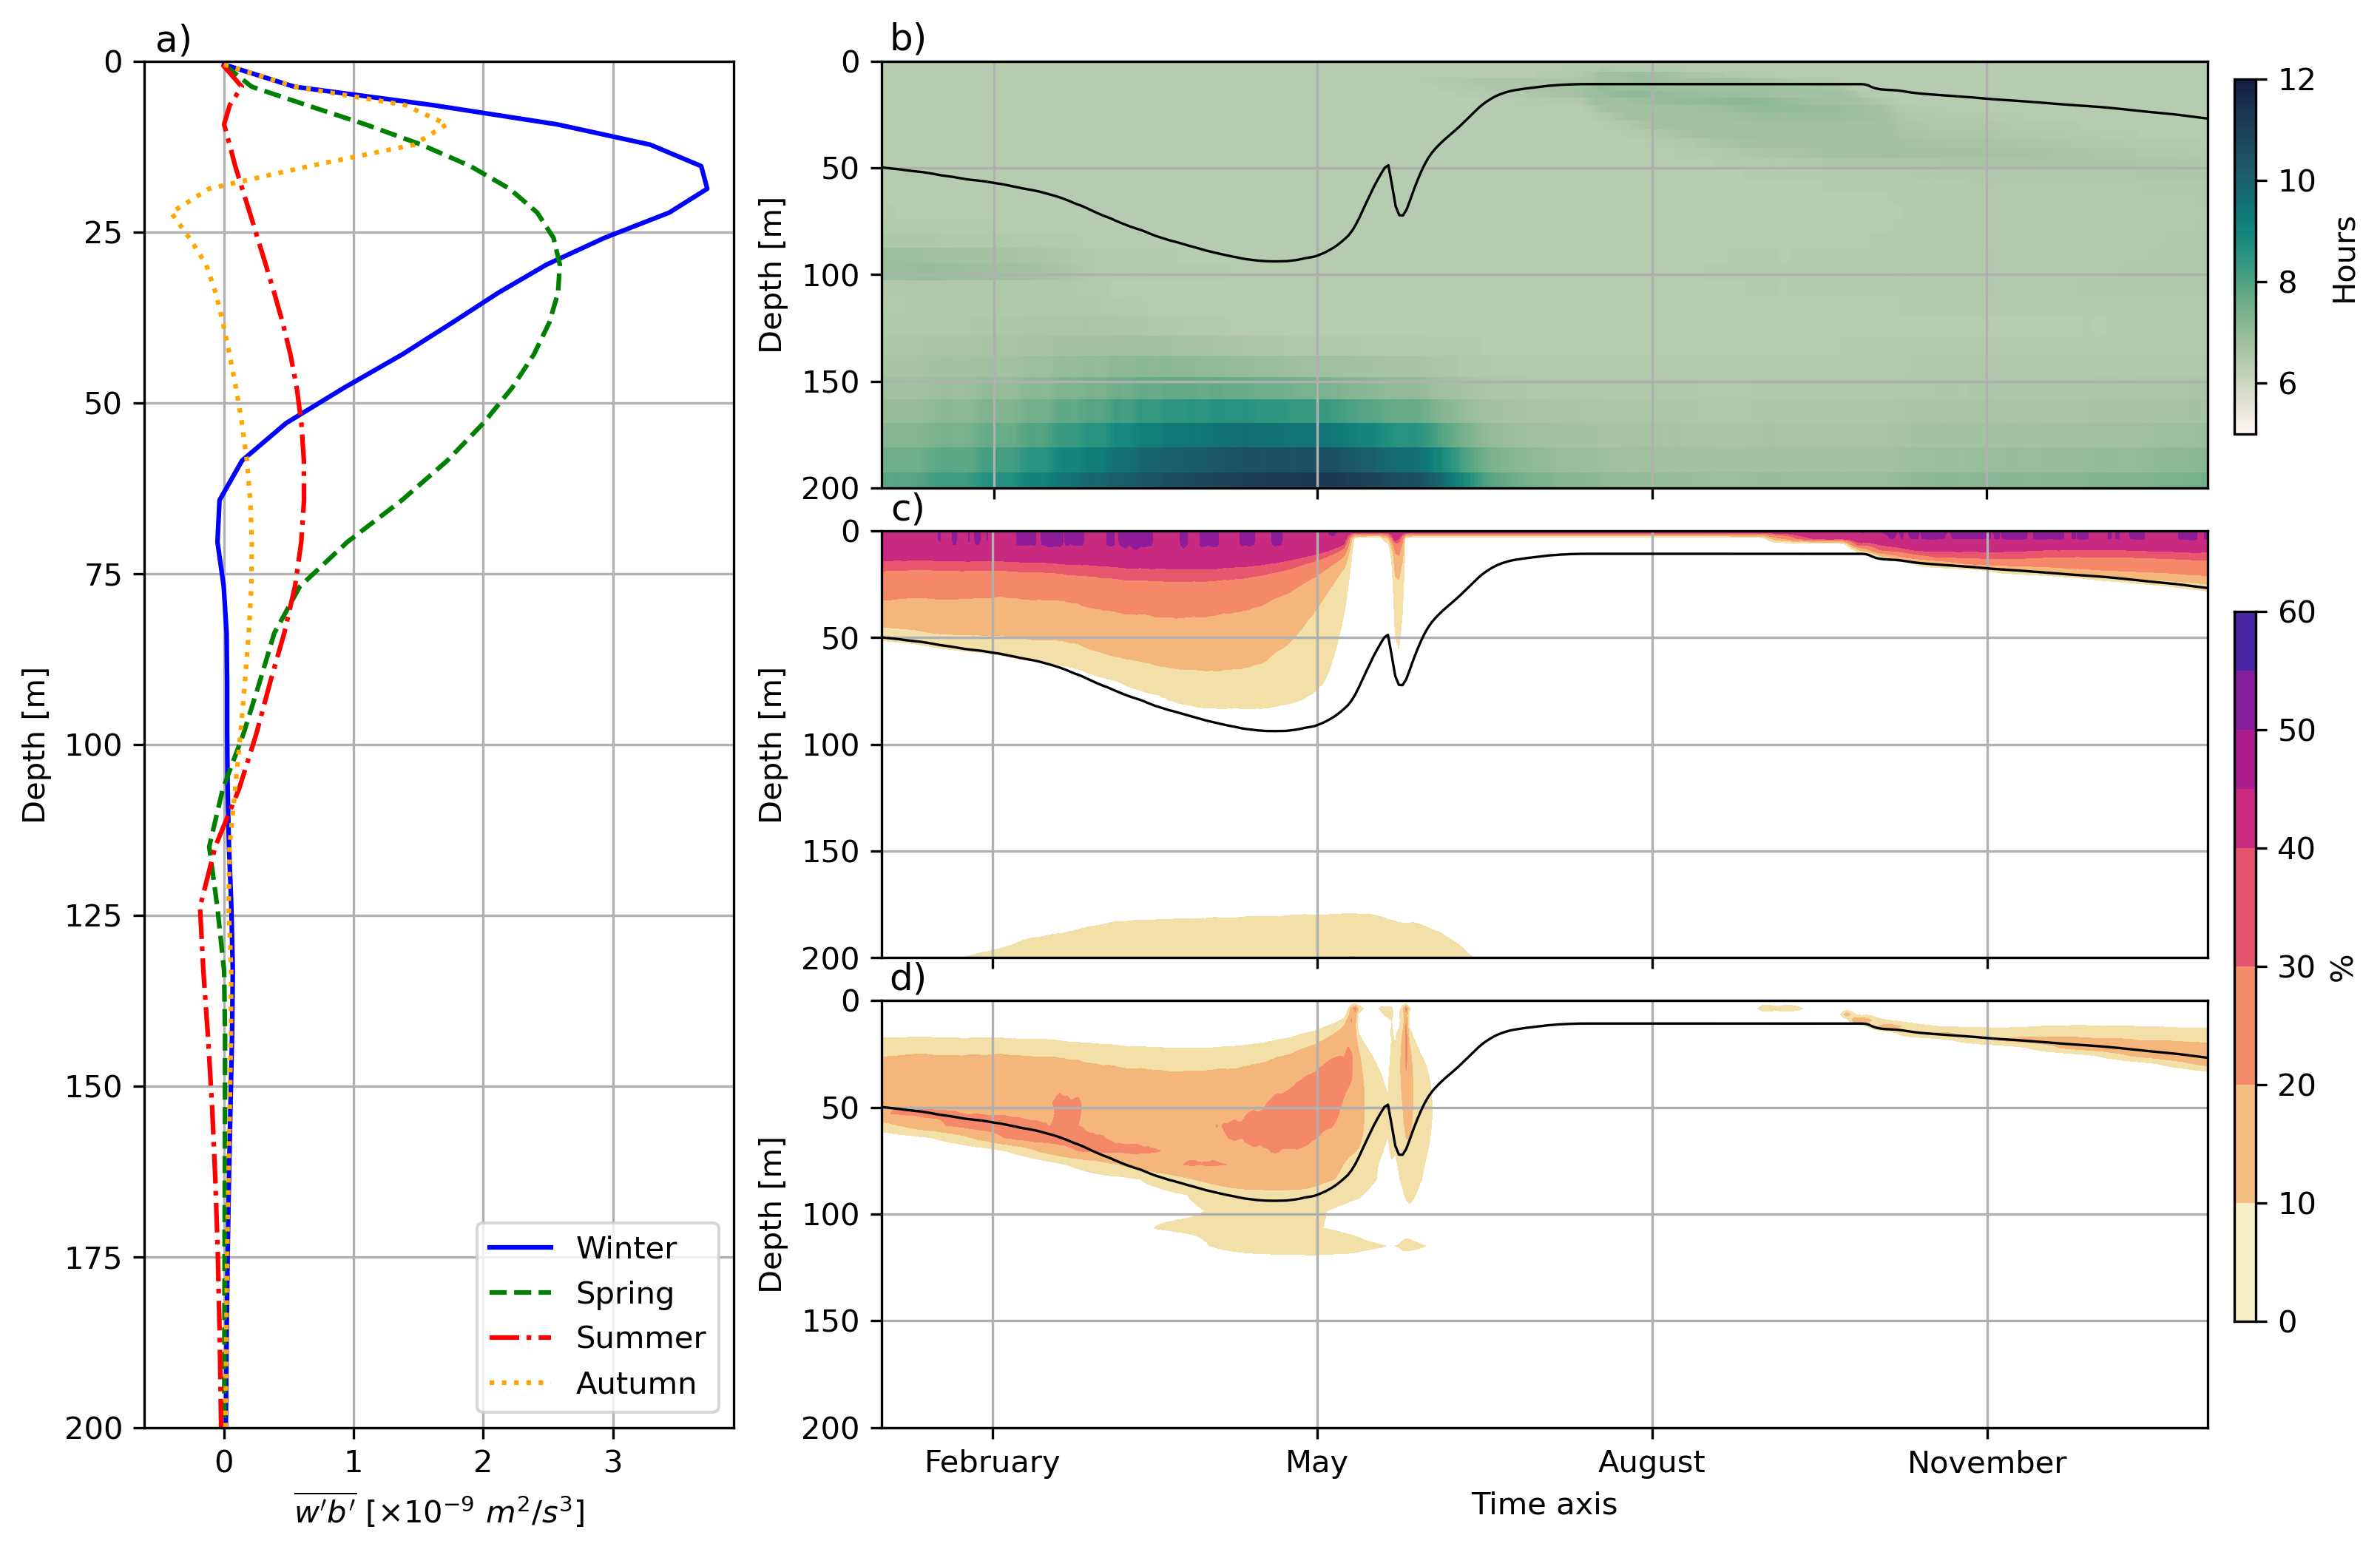

In [21]:
fig = plt.figure(figsize=(12, 8),dpi=300)
gs = GridSpec(3, 3, figure=fig)


ax1 = fig.add_subplot(gs[:, 0])

(1e9*wpbp_seasons_v.sel(season="DJF")).plot(ax=ax1,y="deptht",label="Winter",color="blue")
(1e9*wpbp_seasons_v.sel(season="MAM")).plot(ax=ax1,y="deptht",label="Spring",color="green",linestyle="--")
(1e9*wpbp_seasons_v.sel(season="JJA")).plot(ax=ax1,y="deptht",label="Summer",color="red",linestyle="-.")
(1e9*wpbp_seasons_v.sel(season="SON")).plot(ax=ax1,y="deptht",label="Autumn",color="orange",linestyle=":")

ax1.legend()

ax1.grid()
ax1.set_title("")
ax1.set_xlabel(r"$\overline{w'b'}$ [$\times10^{-9}\ m^2/s^3$]")

# ax2 = fig.add_subplot(gs[0, 1:])

# C1 = ((growth_mode.__xarray_dataarray_variable__)*2*np.pi/1e6).sel(time_counter="0002").plot(x="time_counter",ax=ax2 ,vmin=0,vmax=10, rasterized=True, cmap=cm.cm.turbid,add_colorbar=False)
# ax2.plot(mean_MLD.time_counter.values,mean_MLD,color='k',linewidth=0.5)

ax3 = fig.add_subplot(gs[0, 1:])

C2 = ((time_scale.__xarray_dataarray_variable__)/(60*60)).sel(time_counter="0002").plot(x="time_counter",ax=ax3 ,vmin=5,vmax=12, rasterized=True, cmap=cm.cm.tempo,add_colorbar=False)
ax3.plot(mean_MLD.time_counter.values,mean_MLD,color='k',linewidth=0.8)

ax4 = fig.add_subplot(gs[1, 1:],sharey=ax3)

levels_=[0,10,20,30,40,45,50,55,60]
C3 = (100*stability_data.Percent_Ri_b.sel(time_counter="0002").T).plot.contourf(ax=ax4,vmin=0,vmax=60, levels=levels_,cmap=cct.cm.CET_L17,rasterized=True,add_colorbar=False)
# C3 = (100*stability_data.Percent_Ri_b.sel(time_counter="0002").T).plot(ax=ax4,vmin=50,vmax=100,cmap=cm.cm.amp,rasterized=True,add_colorbar=False)
# np.degrees(np.arctan(-1/Ri_b_ts.__xarray_dataarray_variable__)).sel(time_counter="0002").plot.contour(ax=ax4,color='k',linestyles=':',linewidths=0.7,levels=[-70,0])
ax4.plot(mean_MLD.time_counter.values,mean_MLD,color='k',linewidth=0.8)

ax5 = fig.add_subplot(gs[2, 1:],sharey=ax3)

levels_=[0,10,20,30,40,45,50,55,60]
C3 = (100*mean_baroclinic_instability.Ri_b.sel(time_counter="0002").T).plot.contourf(ax=ax5,vmin=0,vmax=60, levels=levels_,cmap=cct.cm.CET_L17,rasterized=True,add_colorbar=False)
# C3 = (100*stability_data.Percent_Ri_b.sel(time_counter="0002").T).plot(ax=ax4,vmin=50,vmax=100,cmap=cm.cm.amp,rasterized=True,add_colorbar=False)
# np.degrees(np.arctan(-1/Ri_b_ts.__xarray_dataarray_variable__)).sel(time_counter="0002").plot.contour(ax=ax4,color='k',linestyles=':',linewidths=0.7,levels=[-70,0])
ax5.plot(mean_MLD.time_counter.values,mean_MLD,color='k',linewidth=0.8)
# mean_rho.plot.contour(x="time_counter",ax=ax5,levels=np.arange(1020,1028,10),color="gray")
# mean_rho.isel(deptht=slice(0,-2)).plot.contour(ax=ax5,x="time_counter",levels=np.linspace(1025,1028.5,20),colors="k",alpha=0.5)


[a.set_ylim(0,200) for a in [ax1, ax3,ax4,ax5]]
[a.grid() for a in [ax3,ax4,ax5]]

ax1.invert_yaxis()
ax3.invert_yaxis()
# ax4.invert_yaxis()

[ a.set_xticklabels([]) for a in [ax3,ax4]]
[ a.set_xlabel("") for a in [ax3,ax4]]

[a.set_ylabel("Depth [m]") for a in [ax1,ax3,ax4,ax5]]

# cax = fig.add_axes([0.91, 0.66, 0.008, 0.2])
# fig.colorbar(C1, cax=cax, format=ticker.FuncFormatter(myfmt))
# cax.set_ylabel('$km$')

cax = fig.add_axes([0.91, 0.67, 0.008, 0.2])
fig.colorbar(C2, cax=cax, format=ticker.FuncFormatter(myfmt))
cax.set_ylabel('Hours')

cax = fig.add_axes([0.91, 0.17, 0.008, 0.4])
# cbar = fig.colorbar(C3, cax=cax)
x = np.arange(2)
y = np.array([0,10,20,30,40,45,50,55,60])#np.arange(10)
X,Y = np.meshgrid(x,y)
data = Y#np.ones_like(Y)*np.array([50,60,70,80,90,92,94,96,98,100])[:,np.newaxis]
contourf_ = cax.contourf(X, Y, data, levels=[0,10,20,30,40,45,50,55,60], vmin=0, vmax=60, cmap=cct.cm.CET_L17)
cax.yaxis.tick_right()
cax.yaxis.set_label_position("right")
cax.set_xticks([])
cax.set_ylabel('%')
# cbar.set_yticks(ticks=[50,60,70,80,90,92,94,96,98,100], labels=[50,60,70,80,90,92,94,96,98,100])


plt.subplots_adjust(wspace=0.25,hspace=0.1)

ax1.text(0.05, 1.015, 'a)', horizontalalignment='center', verticalalignment='center', transform = ax1.transAxes,fontsize=12)
# ax2.text(0.02, 1.05, 'b)', horizontalalignment='center', verticalalignment='center', transform = ax2.transAxes,fontsize=12)
ax3.text(0.02, 1.05, 'b)', horizontalalignment='center', verticalalignment='center', transform = ax3.transAxes,fontsize=12)
ax4.text(0.02, 1.05, 'c)', horizontalalignment='center', verticalalignment='center', transform = ax4.transAxes,fontsize=12)
ax5.text(0.02, 1.05, 'd)', horizontalalignment='center', verticalalignment='center', transform = ax5.transAxes,fontsize=12)

plt.draw()

labels = [item.get_text() for item in ax5.get_xticklabels()]
updated_labels = [ date_fmt(label[5:10]) for label in labels]
ax5.set_xticklabels(updated_labels,fontsize=10)

plt.savefig('./figures/Fig_8_WpBp_bRi_and_angle.pdf', dpi=300, bbox_inches='tight')

**Figure 8.** a) Profiles of the spatially averaged energy conversion term from EPE to EKE ($w'b'$; Eq. 6) for each season. Hovm\"oller diagrams of b) the Eady time-scale (Eq. 10), c) the horizontal probability of the balanced Richardson angle to meet the ageostrophic instability criteria (Eq. 12), and d) the horizontal probability of the balanced Richardson number to meet the baroclinic instability criteria ($Ri \sim O(1)$). The black solid lines in panels b, c, and d show the ML depth.